### Scaling Preprocessing

- 0 ~ 1 ,-1 ~ 1, z-score 변환 중에서 한 개를 선택하여 범위를 축소하는 작업을 의미한다.
- Pretrained Model은 주로 Tensorflow(tf), torch 프레임워크 방식을 사용한다.
- tf는 -1 ~ 1, torch는 z-score 변환하는 것이 각 프레임워크의 전통이다.

<img src="./images/scaling.png" width="400" style="margin-top:20px;">

In [1]:
with open('./datasets/animals/translate.py') as f:
    content = f.readline()
    contents1 = eval(content[content.index('{'):content.index('}') + 1])
    contents2 = {v : k for k, v in contents1.items()}

print(contents1, contents2, sep='\n')

{'cane': 'dog', 'cavallo': 'horse', 'elefante': 'elephant', 'farfalla': 'butterfly', 'gallina': 'chicken', 'gatto': 'cat', 'mucca': 'cow', 'pecora': 'sheep', 'scoiattolo': 'squirrel', 'dog': 'cane', 'elephant': 'elefante', 'butterfly': 'farfalla', 'chicken': 'gallina', 'cat': 'gatto', 'cow': 'mucca', 'spider': 'ragno', 'squirrel': 'scoiattolo'}
{'dog': 'cane', 'horse': 'cavallo', 'elephant': 'elefante', 'butterfly': 'farfalla', 'chicken': 'gallina', 'cat': 'gatto', 'cow': 'mucca', 'sheep': 'pecora', 'squirrel': 'scoiattolo', 'cane': 'dog', 'elefante': 'elephant', 'farfalla': 'butterfly', 'gallina': 'chicken', 'gatto': 'cat', 'mucca': 'cow', 'ragno': 'spider', 'scoiattolo': 'squirrel'}


In [2]:
from glob import glob
import os

root = './datasets/animals/original/'

directories = glob(os.path.join(root, '*'))

for directory in directories:
    try:
        os.rename(directory, os.path.join(root, contents1[directory[directory.rindex('\\') + 1:]]))
    except KeyError as e:
        os.rename(directory, os.path.join(root, contents2[directory[directory.rindex('\\') + 1:]]))

In [3]:
root = './datasets/animals/original/'

directories = glob(os.path.join(root, '*'))
directory_names = []
for directory in directories:
    directory_names.append(directory[directory.rindex('\\') + 1:])

print(directory_names)

['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']


In [4]:
root = './datasets/animals/original/'

for name in directory_names:
    for i, file_name in enumerate(os.listdir(os.path.join(root, name))):
        old_file = os.path.join(root + name + '/', file_name)
        new_file = os.path.join(root + name + '/', name + str(i + 1) + '.png')

        os.rename(old_file, new_file)

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

idg = ImageDataGenerator(rescale=1./255)

generator = idg.flow_from_directory(root, target_size=(150, 150), batch_size=32, class_mode='categorical')
print(generator.class_indices)

Found 26179 images belonging to 10 classes.
{'butterfly': 0, 'cat': 1, 'chicken': 2, 'cow': 3, 'dog': 4, 'elephant': 5, 'horse': 6, 'sheep': 7, 'spider': 8, 'squirrel': 9}


In [8]:
target_name = {v:k for k,v in generator.class_indices.items()}
target_name

{0: 'butterfly',
 1: 'cat',
 2: 'chicken',
 3: 'cow',
 4: 'dog',
 5: 'elephant',
 6: 'horse',
 7: 'sheep',
 8: 'spider',
 9: 'squirrel'}

In [9]:
target_names = []
for target in generator.classes:
    target_names.append(target_name[target])

In [11]:
# dataframe이 row data인 경우에는 여기서 부터 시작

import pandas as pd

a_df = pd.DataFrame({'file_paths': generator.filepaths, 'target_names': target_names, 'targets': generator.classes})
a_df.loc[:, 'file_paths'] = a_df.file_paths.apply(lambda x: x.replace('\\', '/'))
a_df

,file_paths,target_names,targets
0,./datasets/animals/original/butterfly/butterfl...,butterfly,0
1,./datasets/animals/original/butterfly/butterfl...,butterfly,0
2,./datasets/animals/original/butterfly/butterfl...,butterfly,0
3,./datasets/animals/original/butterfly/butterfl...,butterfly,0
4,./datasets/animals/original/butterfly/butterfl...,butterfly,0
...,...,...,...
26174,./datasets/animals/original/squirrel/squirrel9...,squirrel,9
26175,./datasets/animals/original/squirrel/squirrel9...,squirrel,9
26176,./datasets/animals/original/squirrel/squirrel9...,squirrel,9
26177,./datasets/animals/original/squirrel/squirrel9...,squirrel,9


In [16]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_targets, test_targets =\
train_test_split(a_df.file_paths, a_df.targets, stratify =a_df.targets, test_size=0.2, random_state=124)

print(train_targets.value_counts())
test_targets.value_counts()

targets
4    3890
8    3857
2    2478
6    2098
0    1690
3    1493
9    1490
7    1456
1    1334
5    1157
Name: count, dtype: int64


targets
4    973
8    964
2    620
6    525
0    422
3    373
9    372
7    364
1    334
5    289
Name: count, dtype: int64

In [18]:
train_images, validation_images, train_targets, validation_targets =\
train_test_split(train_images, train_targets, stratify =train_targets, test_size=0.2, random_state=124)


print(train_targets.value_counts())
validation_targets.value_counts()

targets
4    3112
8    3086
2    1982
6    1678
0    1352
3    1194
9    1192
7    1165
1    1067
5     926
Name: count, dtype: int64


targets
4    778
8    771
2    496
6    420
0    338
3    299
9    298
7    291
1    267
5    231
Name: count, dtype: int64

In [25]:
train_df = a_df.iloc[train_images.index].reset_index(drop=True)
validation_df = a_df.iloc[validation_images.index].reset_index(drop=True)
test_df = a_df.iloc[test_images.index].reset_index(drop=True)


print(train_df.shape)
print(validation_df.shape)
print(test_df.shape)

(16754, 3)
(4189, 3)
(5236, 3)


In [31]:
import albumentations as A

IMAGE_SIZE= 64

def transform(image):
    aug = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
    ],p=0.5)

    return aug(image=image)['image']


# flow from dataframe 에서 y_col에 들어갈 타겟 테이터는 문자열 타입만 가능하다.
train_generator = ImageDataGenerator(preprocessing_function=transform, rescale=1./255)
validation_generator = ImageDataGenerator(rescale=1./255)
test_generator = ImageDataGenerator(rescale=1./255)

train_flow = train_generator.flow_from_dataframe(dataframe=train_df, 
                                                x_col = 'file_paths',
                                                y_col='target_names',
                                                target_size = (IMAGE_SIZE,IMAGE_SIZE),
                                                class_mode = 'categorical',
                                                shuffle = True)

validation_flow = validation_generator.flow_from_dataframe(dataframe=validation_df, 
                                                x_col = 'file_paths',
                                                y_col='target_names',
                                                target_size = (IMAGE_SIZE,IMAGE_SIZE),
                                                class_mode = 'categorical')

test_flow = test_generator.flow_from_dataframe(dataframe=test_df, 
                                                x_col = 'file_paths',
                                                y_col='target_names',
                                                target_size = (IMAGE_SIZE,IMAGE_SIZE),
                                                class_mode = 'categorical')
print(train_flow.class_indices)
print(validation_flow.class_indices)
print(test_flow.class_indices)

Found 16754 validated image filenames belonging to 10 classes.
Found 4189 validated image filenames belonging to 10 classes.
Found 5236 validated image filenames belonging to 10 classes.
{'butterfly': 0, 'cat': 1, 'chicken': 2, 'cow': 3, 'dog': 4, 'elephant': 5, 'horse': 6, 'sheep': 7, 'spider': 8, 'squirrel': 9}
{'butterfly': 0, 'cat': 1, 'chicken': 2, 'cow': 3, 'dog': 4, 'elephant': 5, 'horse': 6, 'sheep': 7, 'spider': 8, 'squirrel': 9}
{'butterfly': 0, 'cat': 1, 'chicken': 2, 'cow': 3, 'dog': 4, 'elephant': 5, 'horse': 6, 'sheep': 7, 'spider': 8, 'squirrel': 9}


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, Activation, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResN et50V2
from tensorflow.keras.applications import Xception

In [ ]:
def create_model(model_name='vgg16', verbose= False):
    input tenseor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        model = VGG16(input_tensor = input_tensor, include_top = False, weight='imagenet')
    elif model_name == 'resnet50':
        model = ResNet

In [32]:
def preprocessing_scaling(image, mode='tf'):
    if mode == 'tf': # -1 ~ 1 scale
        image = image/127.5
        image -= 1.
    
    elif mode == 'torch': # z-score scale
        image = image/255.
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        
        image[:, :, 0] = (image[:, :, 0] - mean[0])/std[0]
        image[:, :, 1] = (image[:, :, 1] - mean[1])/std[1]
        image[:, :, 2] = (image[:, :, 2] - mean[2])/std[2]
        
    return image

In [34]:
import cv2
import matplotlib.pyplot as plt

image = cv2.imread((train_df.file_paths.iloc[16749]), cv2.COLOR_BGR2RGB)

In [35]:
scale_image_tf = preprocessing_scaling(image, mode='tf')
scale_image_torch = preprocessing_scaling(image, mode='torch')

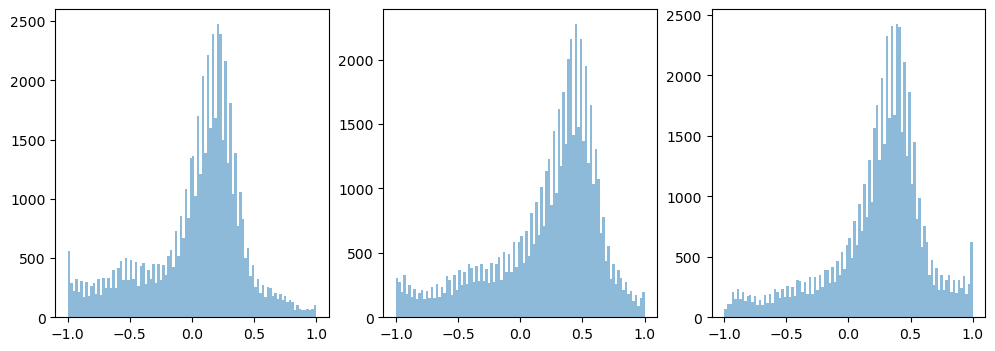

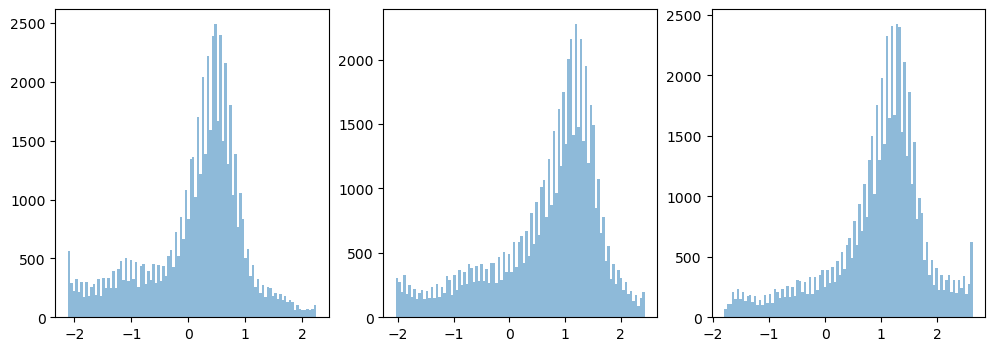

In [37]:
def show_pixel_histogram(image):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
    titles = ['red','blue','green']
    for i in range(3):
        axs[i].hist(image[:,:,i].flatten(),bins=100, alpha=0.5)

show_pixel_histogram(scale_image_tf)
show_pixel_histogram(scale_image_torch)

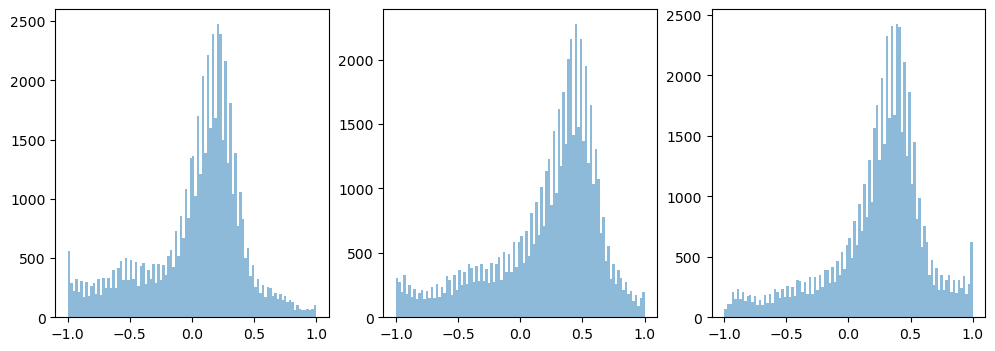

In [39]:
from tensorflow.keras.applications.xception import preprocess_input

# Xception의 scaling 방식은 tf
scaled_image_xception = preprocess_input(image)
show_pixel_histogram(scaled_image_xception)

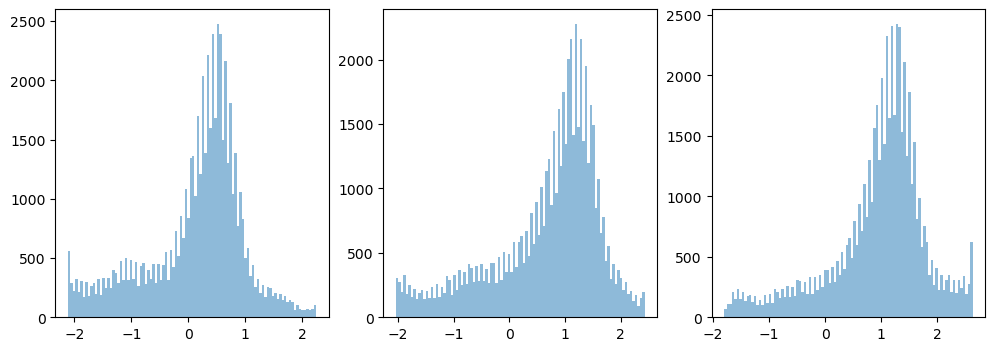

In [41]:
from tensorflow.keras.applications.densenet import preprocess_input

# DenseNet 의 Scaling 방식은 torch
scaled_image_densenet = preprocess_input(image)
show_pixel_histogram(scaled_image_densenet)

In [44]:
import albumentations as A

IMAGE_SIZE= 64

def preprocessing_scaling_for_train(image, mode='tf'):
    aug = A.VerticalFlip(p=0.5)
    image = aug(image=image)['image']
    
    if mode == 'tf': # -1 ~ 1 scale
        image = image/127.5
        image -= 1.
    
    elif mode == 'torch': # z-score scale
        image = image/255.
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        
        image[:, :, 0] = (image[:, :, 0] - mean[0])/std[0]
        image[:, :, 1] = (image[:, :, 1] - mean[1])/std[1]
        image[:, :, 2] = (image[:, :, 2] - mean[2])/std[2]
        
    return image

def preprocessing_scaling(image, mode='tf'):
    if mode == 'tf': # -1 ~ 1 scale
        image = image/127.5
        image -= 1.
    
    elif mode == 'torch': # z-score scale
        image = image/255.
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        
        image[:, :, 0] = (image[:, :, 0] - mean[0])/std[0]
        image[:, :, 1] = (image[:, :, 1] - mean[1])/std[1]
        image[:, :, 2] = (image[:, :, 2] - mean[2])/std[2]
        
    return image



# flow from dataframe 에서 y_col에 들어갈 타겟 테이터는 문자열 타입만 가능하다.
train_generator = ImageDataGenerator(preprocessing_function=preprocessing_scaling_for_train)
validation_generator = ImageDataGenerator(preprocessing_function= preprocessing_scaling)
test_generator = ImageDataGenerator(preprocessing_function= preprocessing_scaling)

train_flow = train_generator.flow_from_dataframe(dataframe=train_df, 
                                                x_col = 'file_paths',
                                                y_col='target_names',
                                                target_size = (IMAGE_SIZE,IMAGE_SIZE),
                                                class_mode = 'categorical',
                                                shuffle = True)

validation_flow = validation_generator.flow_from_dataframe(dataframe=validation_df, 
                                                x_col = 'file_paths',
                                                y_col='target_names',
                                                target_size = (IMAGE_SIZE,IMAGE_SIZE),
                                                class_mode = 'categorical')

test_flow = test_generator.flow_from_dataframe(dataframe=test_df, 
                                                x_col = 'file_paths',
                                                y_col='target_names',
                                                target_size = (IMAGE_SIZE,IMAGE_SIZE),
                                                class_mode = 'categorical')
print(train_flow.class_indices)
print(validation_flow.class_indices)
print(test_flow.class_indices)

Found 16754 validated image filenames belonging to 10 classes.
Found 4189 validated image filenames belonging to 10 classes.
Found 5236 validated image filenames belonging to 10 classes.
{'butterfly': 0, 'cat': 1, 'chicken': 2, 'cow': 3, 'dog': 4, 'elephant': 5, 'horse': 6, 'sheep': 7, 'spider': 8, 'squirrel': 9}
{'butterfly': 0, 'cat': 1, 'chicken': 2, 'cow': 3, 'dog': 4, 'elephant': 5, 'horse': 6, 'sheep': 7, 'spider': 8, 'squirrel': 9}
{'butterfly': 0, 'cat': 1, 'chicken': 2, 'cow': 3, 'dog': 4, 'elephant': 5, 'horse': 6, 'sheep': 7, 'spider': 8, 'squirrel': 9}


NameError: name 'create_model' is not defined